# LPS 2025 – Enabling Open Science with EarthCODE and the Copernicus Dataspace Ecosystem openEO Federation

This notebook presents a complete end-to-end example demonstrating how EarthCODE and the Copernicus Dataspace Ecosystem (CDSE) openEO federation facilitate Open Science. Specifically, it shows how users can create, execute, and publish experiments to the EarthCODE Open Science Catalogue (OSC).

The notebook will guide you through the following steps:

1. **Create a Workflow using openEO**\
A workflow defines the sequence of processing steps to be executed. We will use the CDSE JupyterHub environment, the CDSE openEO federation, and the openEO Python client to build a User Defined Process (UDP).

2. **Create and Run an Experiment**\
In EarthCODE, an experiment corresponds to running a workflow on specific input data with defined parameters, producing an output product. We will create a batch job within the CDSE environment using openEO tools to execute the workflow from Step 1, producing a result product.

3. **Publish the Experiment to the Open Science Catalogue**\
Using EarthCODE tools, we will publish the experiment  to the Open Science Catalogue, simulating how research can be shared with the scientific community.

4. **Reproduce the Experiment**
Finally, we will demonstrate how experiments published in the Open Science Catalogue can be reproduced using the CDSE environment and openEO tools, reinforcing the principles of Open Science.

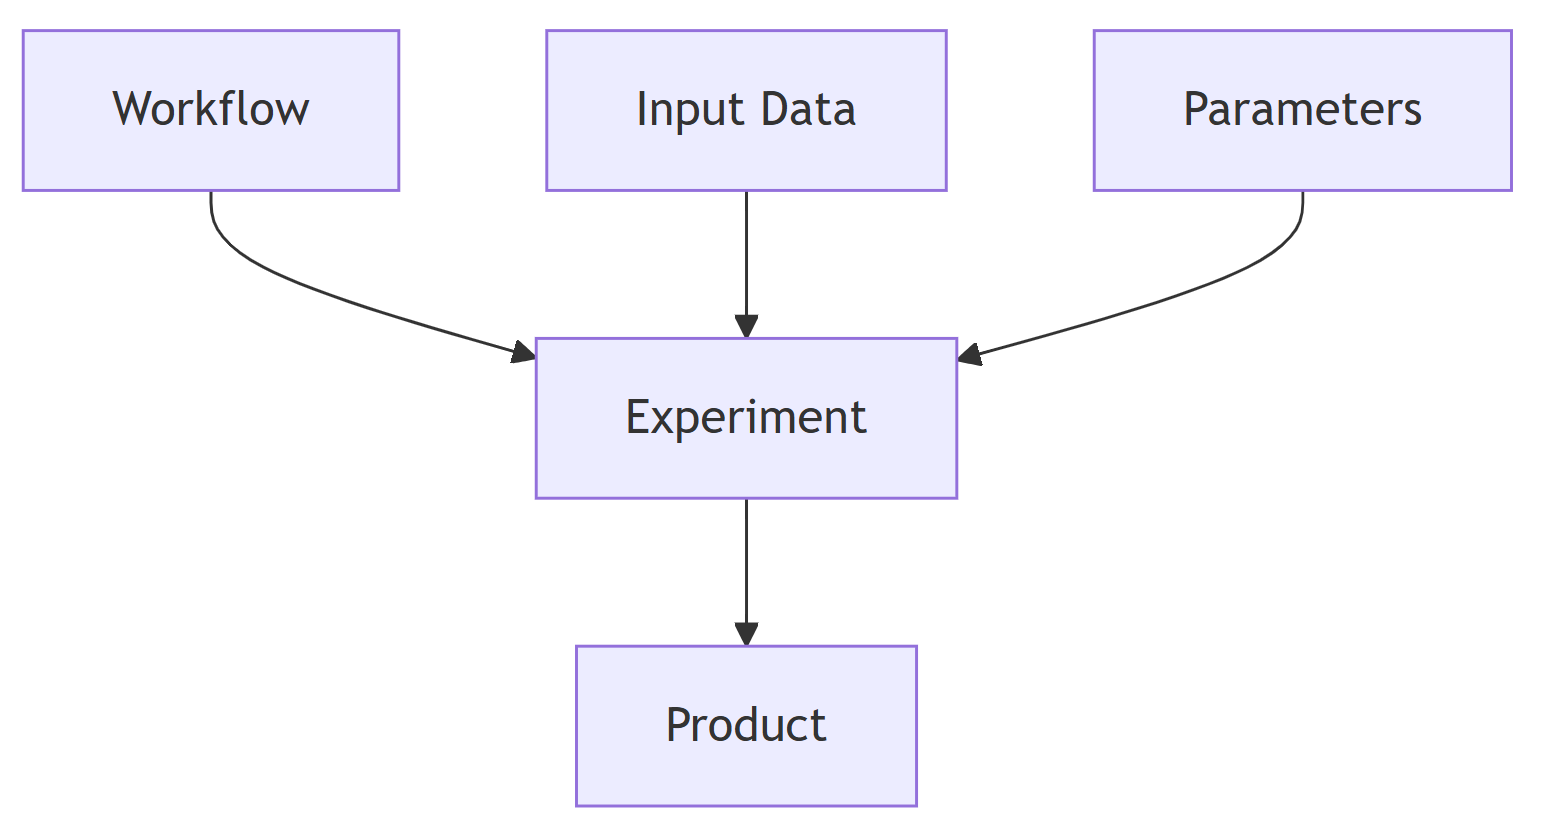
```


In [21]:
import rasterio
import matplotlib.pyplot as plt

def visualise_tif(path: str):
    with rasterio.open(path) as src:
        data = src.read(1)  # Read the first band
        plt.figure(figsize=(10, 10))
        plt.imshow(data, cmap='viridis')
        plt.colorbar()
        plt.show()

## Connection with CDSE openEO Federation

The first step, before creating any processing workflow in openEO, is to authenticate with an available openEO backend. In this example, we will use the CDSE openEO federation, which provides seamless access to both datasets and processing resources across multiple federated openEO backends.

In [22]:
import openeo

In [23]:
connection = openeo.connect(url="openeofed.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


## Step 1 - Creating the worklow
Before we begin creating the experiment, we need to create a workflow in openEO. This workflow will be utilised in our experiment, along with input and output parameters, to generate a specific product. We will build the workflow using an openEO [User Defined Process (UDP)](https://open-eo.github.io/openeo-python-client/udp.html). UDPs allow you to encapsulate your processing workflow, which consists of multiple steps, into reusable openEO building blocks that can be called with a single command.
 
In this notebook, we will create a workflow to generate a variability map. In a variability map, each image pixel is assigned a specific category, which represents the deviation of the pixel value from the mean pixel value. These maps can be used to implement precision agriculture practices by applying different fertilization strategies for each category. For instance, a farmer might choose to apply more product to areas of the field that exhibit a negative deviation and less to those with positive deviations (enhancing poorer areas), or concentrate the application on regions with positive deviations (focusing on the more productive areas of the field).


### Defining the workflow parameters
The first step in creating an openEO workflow is specifying the [input parameters](https://open-eo.github.io/openeo-python-client/api.html#openeo.api.process.Parameter). These parameters enable users to execute the workflow with their own custom settings, making it adaptable to different datasets and use cases. openEO provides built-in [helper functions](https://open-eo.github.io/openeo-python-client/udp.html#process-parameters) that assist in defining these parameters correctly.

In [24]:
from openeo.api.process import Parameter

In [25]:
area_of_interest = Parameter.geojson(name='spatial_extent', description="Spatial extent for which to generate the variability map")
time_of_interest = Parameter.date(name='date', description="Date for which to generate the variability map")

### Implementation of the workflow
Next, we will begin implementing the variability map workflow. This involves using the predefined functions in openEO to create a straightforward workflow consisting of the following steps:
 
  1. Select the S2 data based on the `area_of_interest` and `time_of_interest` parameters.
  2. Calculate the NDVI for the S2 data.
  3. Apply an openEO User Defined Function (UDF) to calculate the deviation of each pixel against the mean pixel value of the datacube.

In [26]:
# Step 1. Select the S2 data based on the workflow parameters
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=area_of_interest,
    temporal_extent=[time_of_interest,time_of_interest],
)
    
s2_masked = s2_cube.mask_polygon(area_of_interest)

In [27]:
# Step 2. Calculate the S2 NDVI
s2_ndvi = s2_masked.ndvi()

In [28]:
# Step 3. Apply the UDF to calculate the variability map
calculate_udf = openeo.UDF.from_file("variability_map.py")
varmap_dc = s2_ndvi.reduce_temporal(calculate_udf)

In [29]:
from IPython.display import JSON

JSON(varmap_dc.to_json())

<IPython.core.display.JSON object>

### Create an openEO-based workflow
In this next step, we will create our workflow by establishing our openEO User Defined Process (UDP). This action will create a public reference to the workflow we developed in the preceding steps. This can be achieved by using the [`save_user_defined_process`](https://open-eo.github.io/openeo-python-client/api.html#openeo.rest.connection.Connection.save_user_defined_process) function.

In [30]:
connection.save_user_defined_process(
    "variability_map",
    varmap_dc,
    parameters=[area_of_interest, time_of_interest],
    public=True
)

Preflight process graph validation raised: [UpstreamValidationInfo] Backend 'cdse' reported validation errors [ProcessParameterRequired] Process 'n/a' parameter 'spatial_extent' is required.


## Step 2 - Creating an experiment
With our workflow successfully created as an openEO User Defined Process (UDP), we can now set up an experiment. This involves executing the workflow with a predefined set of input parameters. By specifying parameters such as the area of interest and time range, we can tailor the experiment to generate meaningful results.
 
Running the experiment will produce output products, which will be displayed at the end of the notebook. These results can then be further analyzed, shared with the scientific community, or published in the EarthCODE Open Science Catalogue to promote reproducibility and collaboration.

In [12]:
spatial_extent_value = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              5.170043941798298,
              51.25050990858725
            ],
            [
              5.171035037521989,
              51.24865722468999
            ],
            [
              5.178521828188366,
              51.24674578027137
            ],
            [
              5.179084341977159,
              51.24984764553983
            ],
            [
              5.170043941798298,
              51.25050990858725
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

date_value = "2025-05-01"

We can now execute our experiment using the `datacube_from_process` function and the information from the workflow we created:

* `process_id`: the ID that we have assigned to our workflow
* `namespace`: the public URL of the workflow, which is provided as output of the `save_user_defined_process` call
* `**kwargs`: the parameters of the workflow. If a parameter is not specified, its default value will be used

In [13]:
varmap_experiment = connection.datacube_from_process(
    process_id="variability_map",
    namespace="https://openeo.dataspace.copernicus.eu/openeo/1.1/processes/u:6391851f-9042-4108-8b2a-3dd2e8a9dd0b/variability_map",
    spatial_extent=spatial_extent_value,
    date=date_value
)

Now that we have created our experiment, we can explore how it is defined within openEO.

In [14]:
JSON(varmap_experiment.to_json())

<IPython.core.display.JSON object>

0:00:00 Job 'cdse-j-25061909182942a1a8066c844348fa89': send 'start'
0:00:14 Job 'cdse-j-25061909182942a1a8066c844348fa89': created (progress 0%)
0:00:19 Job 'cdse-j-25061909182942a1a8066c844348fa89': created (progress 0%)
0:00:26 Job 'cdse-j-25061909182942a1a8066c844348fa89': created (progress 0%)
0:00:34 Job 'cdse-j-25061909182942a1a8066c844348fa89': created (progress 0%)
0:00:45 Job 'cdse-j-25061909182942a1a8066c844348fa89': running (progress N/A)
0:00:57 Job 'cdse-j-25061909182942a1a8066c844348fa89': running (progress N/A)
0:01:13 Job 'cdse-j-25061909182942a1a8066c844348fa89': running (progress N/A)
0:01:32 Job 'cdse-j-25061909182942a1a8066c844348fa89': running (progress N/A)
0:01:57 Job 'cdse-j-25061909182942a1a8066c844348fa89': finished (progress 100%)


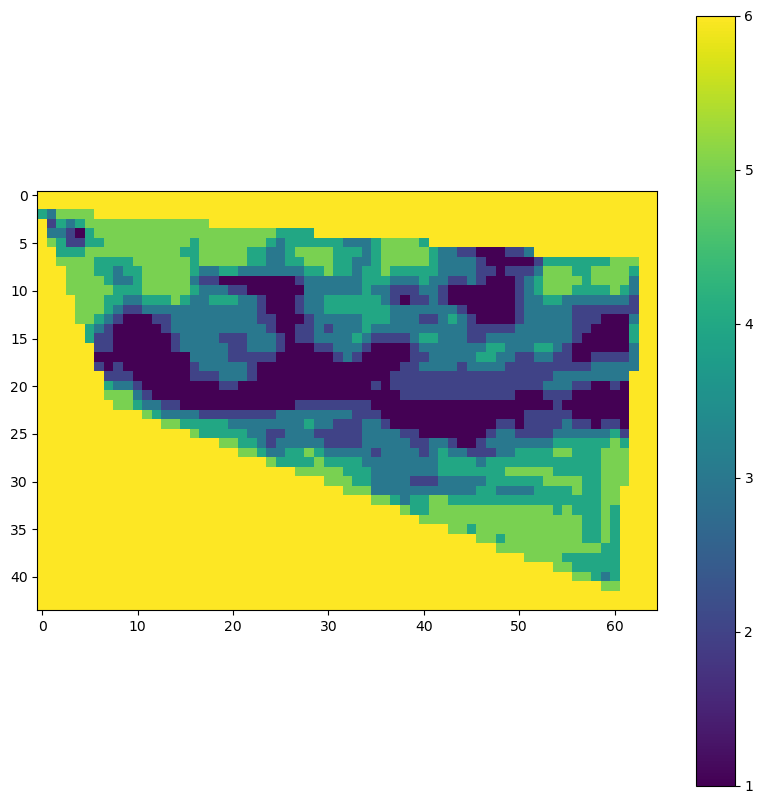

In [15]:
path =  "./varmap_experiment.tiff"
varmap_experiment.execute_batch(
    path,
    title="CDSE Federation - LPS 2025 - Variability Map Experiment", 
    description="This is an example experiment from CDSE containing the calculation of a variability map in Belgium",
)
visualise_tif(path)


## Step 3 - Publish the experiment to the OSC

The next step is to publish the experiment to the EarthCODE Open Science Catalogue. This can be done by navigating to the [openEO Publishing tool](https://publish.earthcode.vito.be/), which will guide you through the process of publishing the experiment. The publishing tool will create a GitHub pull request on the OSC with all the necessary information required to publish the experiment, including details about the product and the workflow. The experiment will only be available in the catalogue once the pull request is approved. However, for the purpose of this demonstration, we can proceed with the information available in the pull request.

The only information you'll need to publish the experiment is the URL to your workflow. This corresponds to the public URL of the UDP that was created in previous steps. In this case, the workflow URL is https://openeo.dataspace.copernicus.eu/openeo/1.1/processes/u:6391851f-9042-4108-8b2a-3dd2e8a9dd0b/variability_map


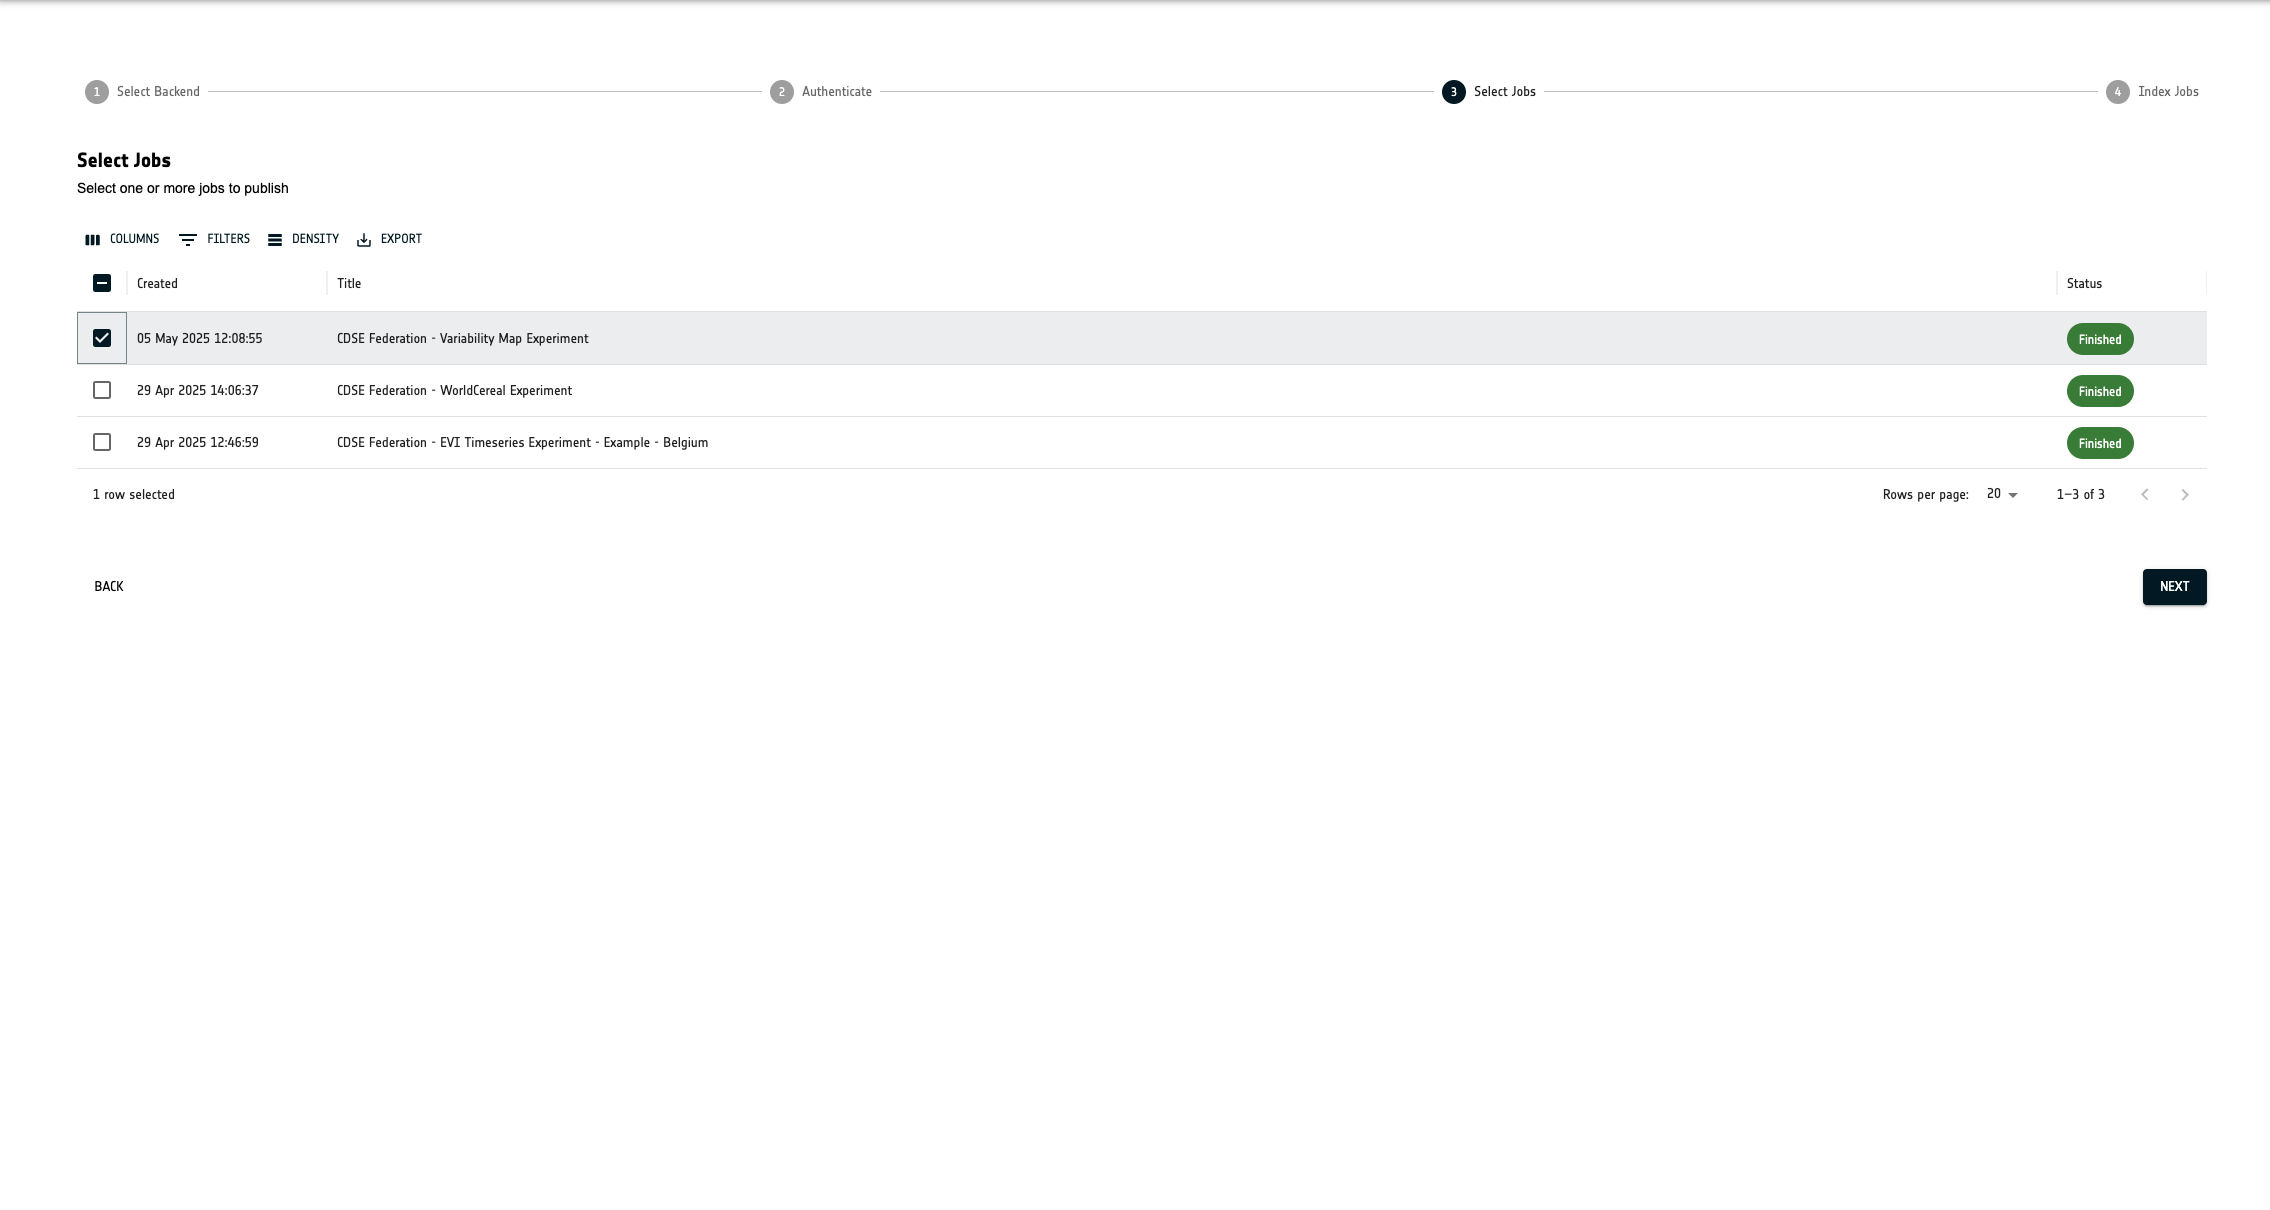


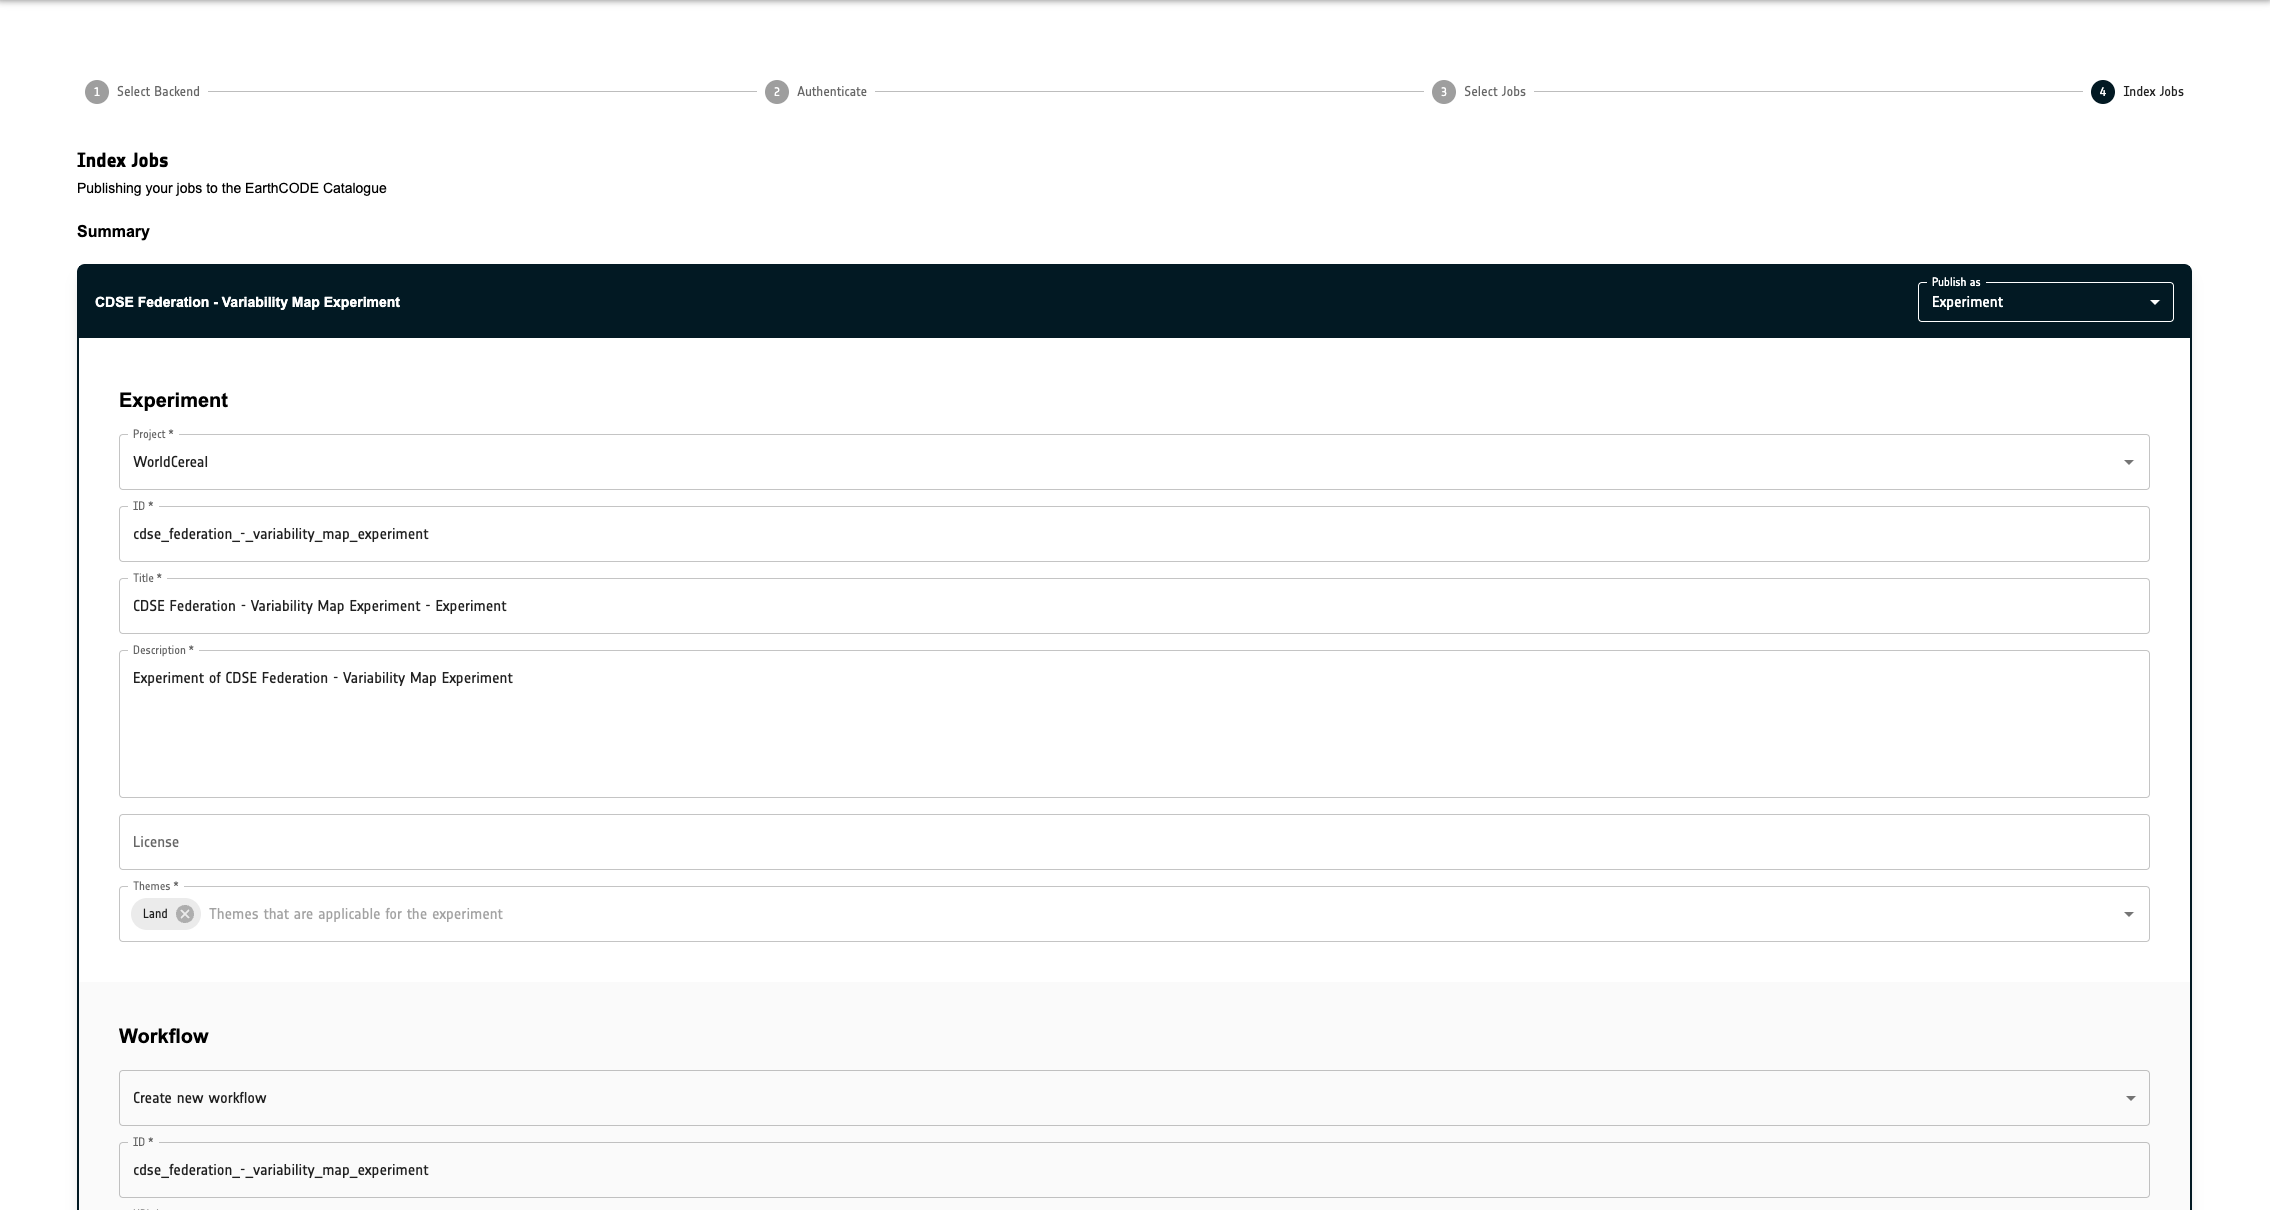


## Step 4 - Reproduce the experiment from the OSC
In this final step, we will use your newly published experiment and reproduce it. As the published experiment is still in review on the PR, we will use the information on GitHub to re-execute our experiment. The URL that we need needs to refer to the following file experiments/experiment_id/process_graph.json. 

In [16]:
experiment_url = "https://raw.githubusercontent.com/ESA-EarthCODE/open-science-catalog-metadata-testing/631bda3e59cb6eec9b6cfc1b2edb68778f8f1edc/experiments/cdse_federation_-_lps_2025_-_variability_map_experiment/process_graph.json"

### Using the openEO client
The first option to execute an existing experiment is through the openEO Python client. By using openEO's `datacube_from_json`, you can import the published experiment from the OSC into openEO.

In [17]:
experiment = connection.datacube_from_json(experiment_url)
JSON(experiment.to_json())

<IPython.core.display.JSON object>

0:00:00 Job 'cdse-j-250619092230432c80381a66e4d22e25': send 'start'
0:00:14 Job 'cdse-j-250619092230432c80381a66e4d22e25': created (progress 0%)
0:00:19 Job 'cdse-j-250619092230432c80381a66e4d22e25': created (progress 0%)
0:00:25 Job 'cdse-j-250619092230432c80381a66e4d22e25': created (progress 0%)
0:00:34 Job 'cdse-j-250619092230432c80381a66e4d22e25': created (progress 0%)
0:00:44 Job 'cdse-j-250619092230432c80381a66e4d22e25': running (progress N/A)
0:00:56 Job 'cdse-j-250619092230432c80381a66e4d22e25': running (progress N/A)
0:01:13 Job 'cdse-j-250619092230432c80381a66e4d22e25': running (progress N/A)
0:01:33 Job 'cdse-j-250619092230432c80381a66e4d22e25': running (progress N/A)
0:01:57 Job 'cdse-j-250619092230432c80381a66e4d22e25': finished (progress 100%)


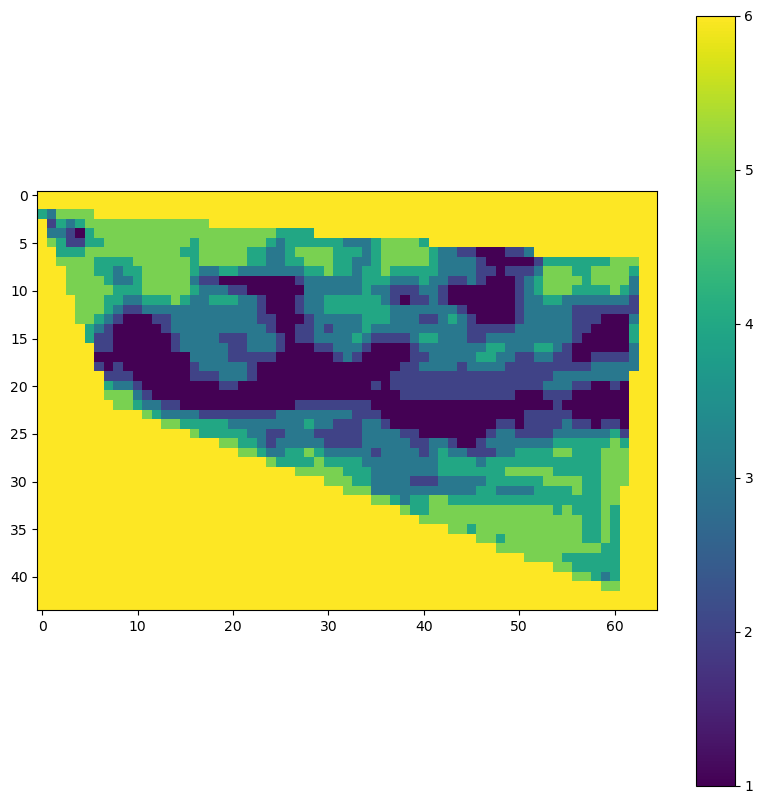

In [18]:
path =  "./varmap_experiment_reproduce.tiff"
experiment.execute_batch(
    path,
    title="CDSE Federation - Variability Map Experiment (reproduce)"
)
visualise_tif(path)

In [19]:
import numpy as np


def compare_geotiff(file1: str, file2: str) -> bool:
    with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
        # Check if dimensions match
        if src1.width != src2.width or src1.height != src2.height:
            return False
        
        # Check if coordinate reference systems match
        if src1.crs != src2.crs:
            return False
        
        # Check if transform properties match
        if src1.transform != src2.transform:
            return False
        
        # Compare pixel values
        data1 = src1.read()
        data2 = src2.read()
        if not np.array_equal(data1, data2):
            return False

    return True

# Call the function with the specified files
are_equal = compare_geotiff("./varmap_experiment.tiff", "./varmap_experiment_reproduce.tiff")
print(f"Are the GeoTIFF files equal? {are_equal}")

Are the GeoTIFF files equal? True


### Using the openEO Web Editor

Alternatively, you can also open the experiment through the [openEO Web Editor](https://openeofed.dataspace.copernicus.eu) using the experiment URL. This can be done by clicking the 'Import process from an external source' button located in the top navigation bar.

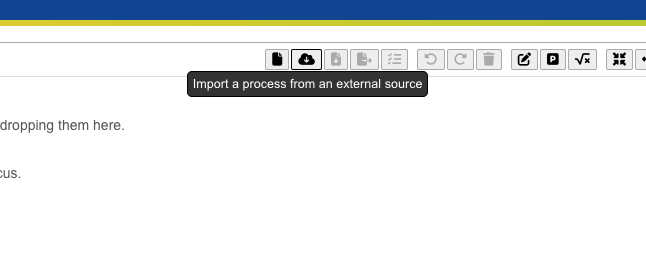

Next, paste the experiment URL into the window to fetch the experiment and open it in the editor.

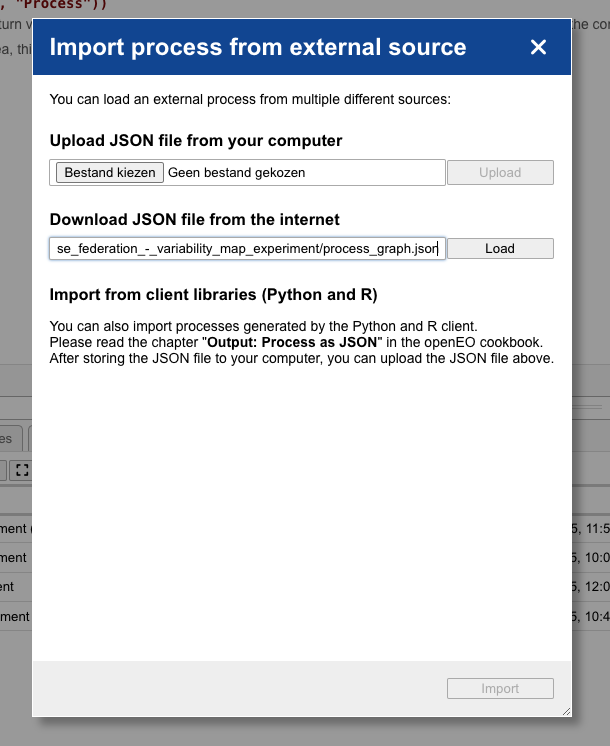

Finally, click the 'Create Batch Job' button to initiate the execution of the experiment.

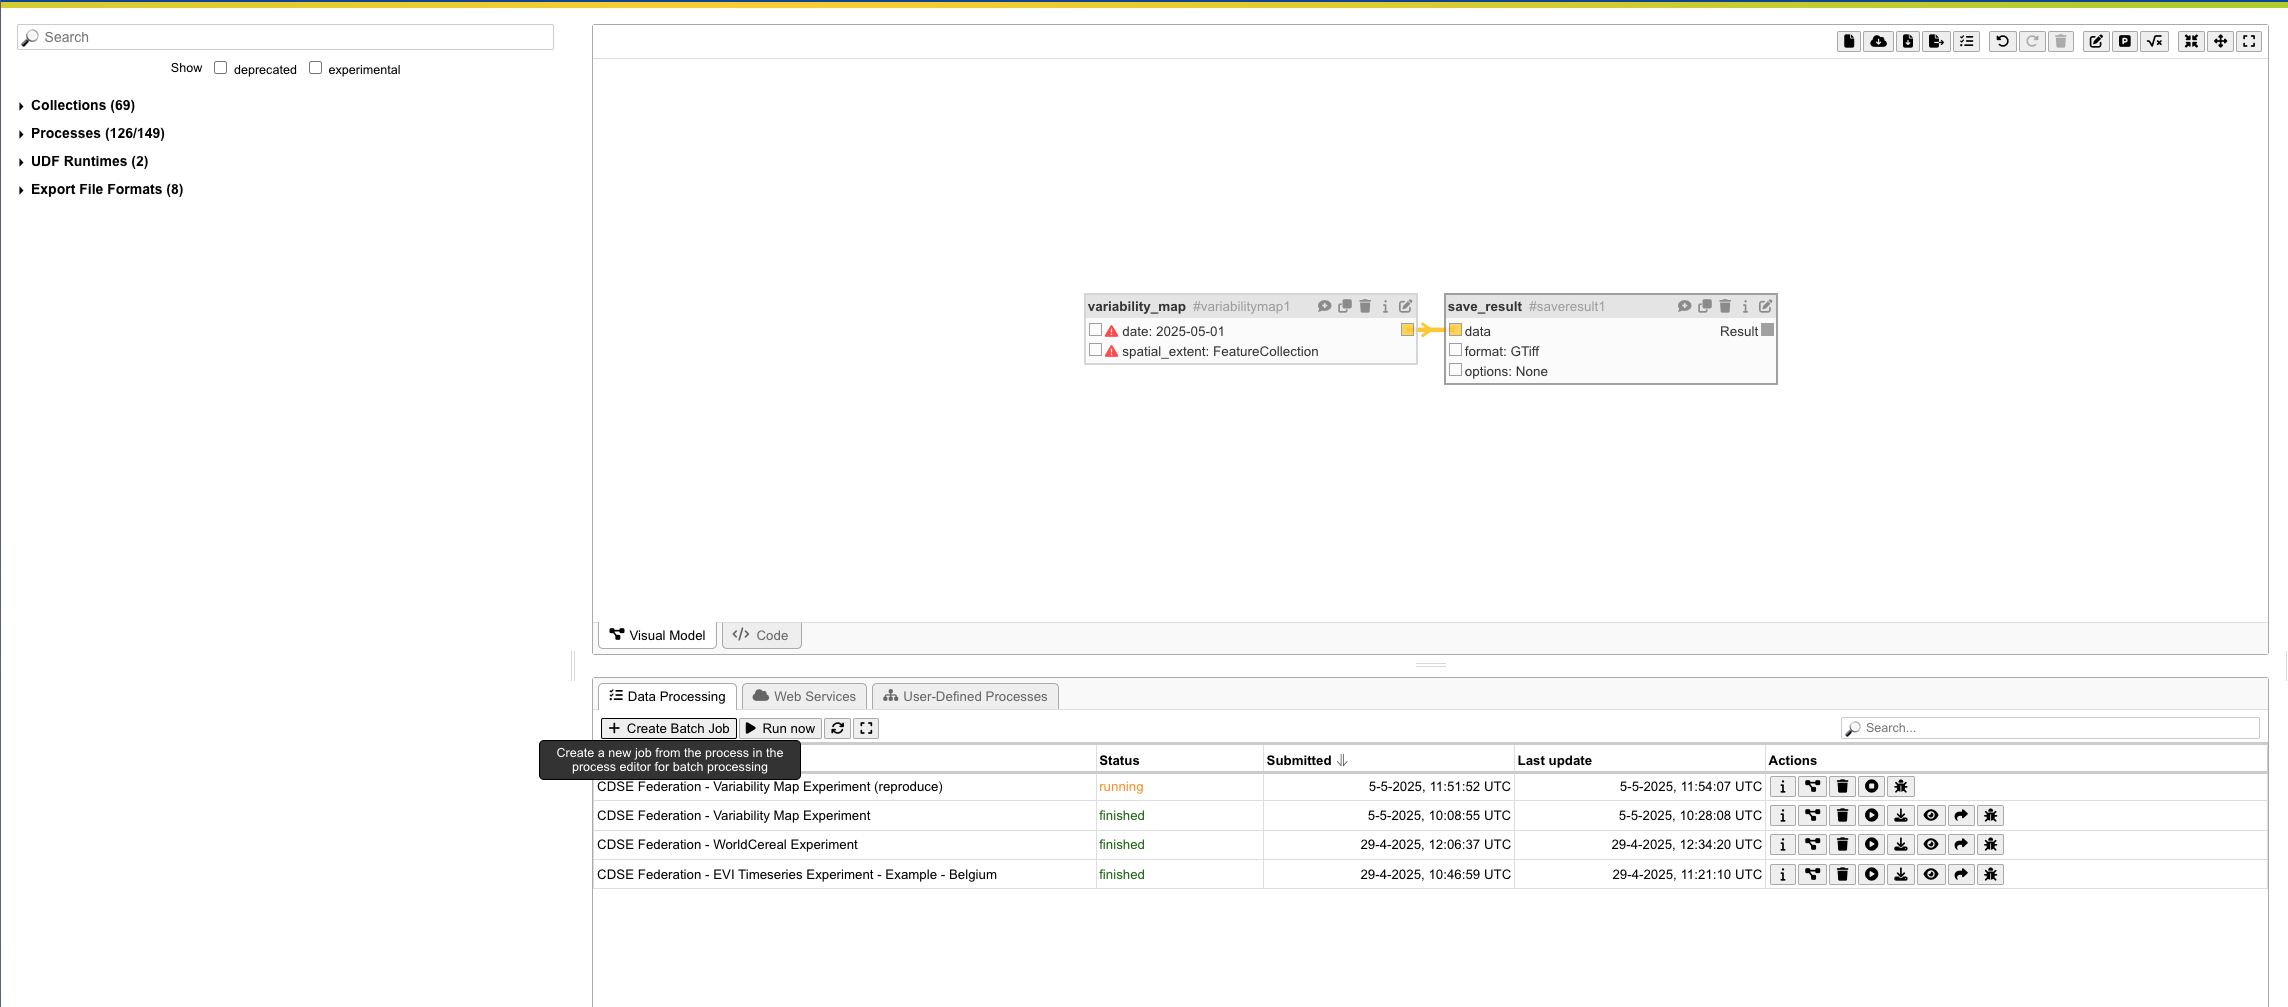